## Loading the Dataset

In [1]:
import pandas as pd

data = pd.read_csv('pred_main_dataset.csv')

print(data.head())


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

## Data Exploration

In [2]:
# Check data types
print(data.dtypes)

# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000  

## Feature Engineering

In [3]:
data['Any_failure'] = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].max(axis=1)

### Interaction Features

In [4]:
data['Speed_Torque_Interaction'] = data['Rotational speed [rpm]'] * \
    data['Torque [Nm]']

print(data[['Rotational speed [rpm]', 'Torque [Nm]',
      'Speed_Torque_Interaction']].head())

   Rotational speed [rpm]  Torque [Nm]  Speed_Torque_Interaction
0                    1551         42.8                   66382.8
1                    1408         46.3                   65190.4
2                    1498         49.4                   74001.2
3                    1433         39.5                   56603.5
4                    1408         40.0                   56320.0


### Exploratory Data Analysis

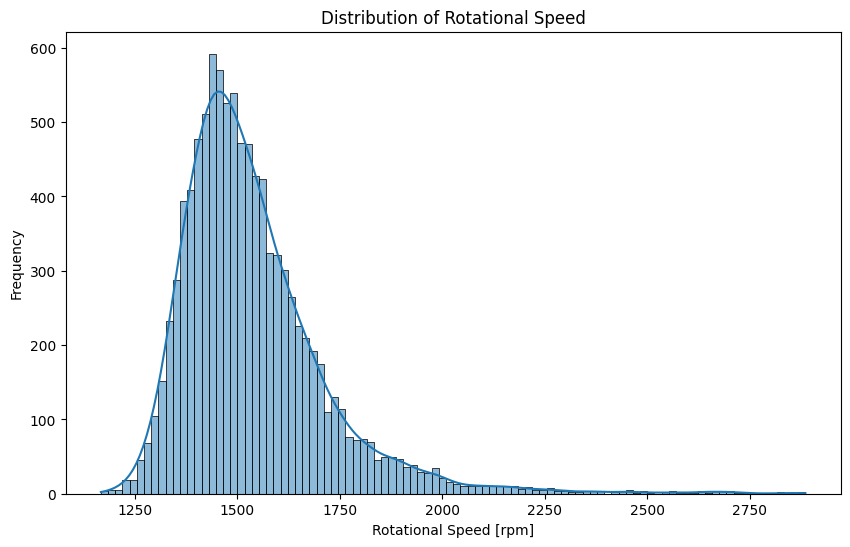

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['Rotational speed [rpm]'], kde=True)
plt.title('Distribution of Rotational Speed')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')
plt.show()

#### Visualising the Relationship Between Rotational Speed, Torque, and Machine Failure

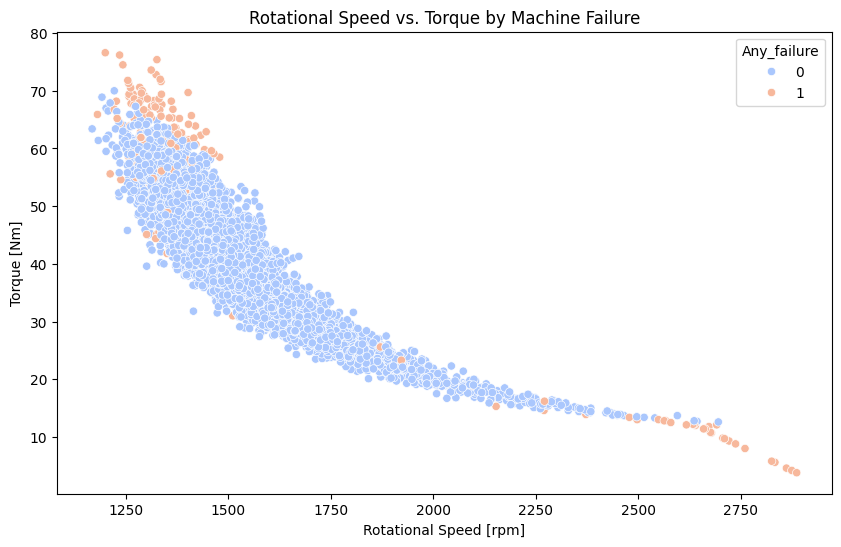

In [6]:
# Scatter plot of Rotational Speed vs. Torque, coloured by Machine Failure
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]',
                hue='Any_failure', data=data, palette='coolwarm')
plt.title('Rotational Speed vs. Torque by Machine Failure')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()

### Data Splitting

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['Any_failure'])

print("Training set failure distribution:")
print(train_data['Any_failure'].value_counts(normalize=True))

print("Test set failure distribution:")
print(test_data['Any_failure'].value_counts(normalize=True))

Training set failure distribution:
Any_failure
0    0.96525
1    0.03475
Name: proportion, dtype: float64
Test set failure distribution:
Any_failure
0    0.965
1    0.035
Name: proportion, dtype: float64


### Model Training and Evaluation

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define features and target
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]', 'Speed_Torque_Interaction']
target = 'Any_failure'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC Scores
print("Logistic Regression ROC-AUC Score:",
      roc_auc_score(y_test, y_pred_log_reg))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost (as an example)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost Confusion Matrix:")
print(conf_matrix_xgb)

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D3923ACB-D836-32D3-A031-CF91999FDAFC> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file)